In [0]:
# import libraries and settings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
pd.set_option('display.float_format', lambda x: '%.2f' % x)
plt.style.use('fivethirtyeight')

In [2]:
# import auction data and drop un needed columns
auction_history = pd.read_csv('https://raw.githubusercontent.com/AndrewMarksArt/DS-Unit-1-Sprint-5-Data-Storytelling-Blog-Post/master/Damien_Hirst_Auction_Results.csv')
auction_history.drop(['ID_Batch_Loop#', 'Artist_Name', 'Date_Created', 'Size'], axis=1, inplace=True)
auction_history = auction_history.rename(columns={'Sale_Date': 'Date'})
auction_history.head()

,Title,Medium,Signed_Edition,Estimate_Range,Realized_Price,Sale,Auction_House,Date
0,"SPOT DRAWING NO. 2, 1990",coloured pencil on paper,Signed,"80,000 - 120,000 GBP","175,000 GBP",Contemporary Art Day Auction,Sotheby's London,"Jun. 27, 2018"
1,"Supreme Skate Deck Red #7, 1987",Color silkscreen on plywood in original,from an edition of 500,"800 - 1,200 USD",450 USD*,"Public Art Auction: Modern & Contemporary Art,...",Santa Monica Auctions,"Jun. 04, 2017"
2,"Supreme Skate Deck Yellow #6, 1987",Color silkscreen on plywood in original bag,from an edition of 500,"800 - 1,200 USD",475 USD*,"Public Art Auction: Modern & Contemporary Art,...",Santa Monica Auctions,"Jun. 04, 2017"
3,"Pharmacy, circa1990",offset lithograph printed in colours,42/200,"1,500 - 2,000 GBP","1,500 GBP",Mixed Media: 20th Century Art,"Dreweatts & Bloomsbury Auctions, Bloomsbury House","Jul. 16, 2015"
4,"The Complete Spot Paintings, 1986-2011",with butterfly and heart drawing on the slipca...,Signed,"1,000 - 1,500 GBP","2,375 GBP",Prints & Multiples,Bonhams Knightsbridge,"Jun. 03, 2015"


In [3]:
# import fx data and drop the realized price
fx = pd.read_csv('https://raw.githubusercontent.com/AndrewMarksArt/DS-Unit-1-Sprint-5-Data-Storytelling-Blog-Post/master/cleaned_fx_data_with_prices.csv')
fx.drop(columns=['Realized_Price'], inplace=True)
fx.head()

,Date,Country,Value
0,2018-06-27,United Kingdom,0.76
1,2015-07-16,United Kingdom,0.64
2,2015-06-03,United Kingdom,0.65
3,2015-03-10,United Kingdom,0.66
4,2014-10-23,United Kingdom,0.62


In [0]:
# create var for the estimate range column from auction data
estimate = auction_history['Estimate_Range']

# create empty lists that will be used to create new columns 
low = []
high = []
currency = []

# loop through elements in the estimate range
# pull out low estimate, high estimate and currency
for i in range(len(estimate)):
  est = estimate[i]
  try:
    temp = est.split()
    if len(temp) == 4:
      low.append(temp[0])
      high.append(temp[2])
      currency.append(temp[3])
    elif len(temp) == 2:
      low.append(temp[0])
      high.append(np.nan)
      currency.append(temp[1])
    else:
      low.append(np.nan)
      high.append(np.nan)
      currency.append(np.nan)
  except:
    pass

# use the lists to create new columns for the auction data 
auction_history['Low Estimate'] = low
auction_history['High Estimate'] = high
auction_history['Currency'] = currency

# drop estimate range since it is now redundant 
auction_history.drop(['Estimate_Range'], axis=1, inplace=True)

In [0]:
# create var to hold realized prices from aution data
prices = auction_history['Realized_Price']

# loop through realized prices to remove currency codes
for i in range(len(prices)):
  try:
    temp = prices[i].split()
    if len(temp) < 2:
      prices[i] = -1
    else:
      prices[i] = temp[0]
  except:
    pass
  
# replace realized prices so new values have no currency codes
auction_history['Realized_Price'] = prices

In [7]:
auction_history.head()

,Title,Medium,Signed_Edition,Realized_Price,Sale,Auction_House,Date,Low Estimate,High Estimate,Currency
0,"SPOT DRAWING NO. 2, 1990",coloured pencil on paper,Signed,"175,000",Contemporary Art Day Auction,Sotheby's London,"Jun. 27, 2018","80,000","120,000",GBP
1,"Supreme Skate Deck Red #7, 1987",Color silkscreen on plywood in original,from an edition of 500,450,"Public Art Auction: Modern & Contemporary Art,...",Santa Monica Auctions,"Jun. 04, 2017",800,"1,200",USD
2,"Supreme Skate Deck Yellow #6, 1987",Color silkscreen on plywood in original bag,from an edition of 500,475,"Public Art Auction: Modern & Contemporary Art,...",Santa Monica Auctions,"Jun. 04, 2017",800,"1,200",USD
3,"Pharmacy, circa1990",offset lithograph printed in colours,42/200,"1,500",Mixed Media: 20th Century Art,"Dreweatts & Bloomsbury Auctions, Bloomsbury House","Jul. 16, 2015","1,500","2,000",GBP
4,"The Complete Spot Paintings, 1986-2011",with butterfly and heart drawing on the slipca...,Signed,"2,375",Prints & Multiples,Bonhams Knightsbridge,"Jun. 03, 2015","1,000","1,500",GBP


In [0]:
# set var for currency column
currency = auction_history['Currency']

# loop through currency and remove * and Sold values
for i in range(len(currency)):
  try:
    if '*' in currency[i]:
      currency[i] = 'EUR'
    if 'Sold' in currency[i]:
      currency[i] = np.nan
  except:
    pass

# replace currency with new list that removed * and Sold
auction_history['Currency'] = currency

In [0]:
# fill remaining NaN's in currency column with 'USD'
auction_history['Currency'].fillna('USD', inplace=True)

In [0]:
# set up dictionary with currency code as keys and country names as the values
country_dict = {'GBP': 'United Kingdom', 'USD': 'United States', 'EUR': 'Europe', 'HKD': 'Hong Kong', 'CNY': 'China', 'CHF': 'Switzerland',
             'SEK': 'Sweden', 'JPY': 'Japan', 'KRW': 'South Korea', 'AUD': 'Australia', 'NOK': 'Norway', 'ZAR': 'South Africa', 'DKK': 'Denmark', 'NZD': 'New Zealand', 
               'TWD': 'Taiwan', 'SGD': 'Singapore', 'MXN': 'Mexico', 'CZK': 'Czech Republic'}

In [0]:
# set currency column to new var and create list for countries
currency = auction_history['Currency']
country = []

# loop through currency column and get the country name that corresponds to the currency code 
for i in range(len(currency)):
  try:
    country.append(country_dict.get(currency[i]))
  except:
    pass
    
# create a county column with the counrty list
auction_history['Country'] = country

In [0]:
# replace no sale date listed with NaN
sale = auction_history['Date']
for i in range(len(sale)):
  try:
    if 'no' in sale[i]:
      sale[i] = np.nan
  except:
    pass

In [0]:
auction_history['Date'] = pd.to_datetime(auction_history['Date'])

In [0]:
price = []

for i in range(len(auction_history['Realized_Price'])):
  try:
    if 'Not' in auction_history['Realized_Price'][i]:
      price.append(0)
    elif 'not' in auction_history['Realized_Price'][i]:
      price.append(0)
    else:
      price.append(auction_history['Realized_Price'][i])
  except:
    price.append(0)

auction_history['Realized_Price'] = price

auction_history['Realized_Price'] = auction_history['Realized_Price'].str.replace(',','')
auction_history['Low Estimate'] = auction_history['Low Estimate'].str.replace(',','')
auction_history['High Estimate'] = auction_history['High Estimate'].str.replace(',','')

In [0]:
auction_history['Realized_Price'] = auction_history['Realized_Price'].fillna(0)
auction_history = auction_history.dropna(subset=['Low Estimate'])
low = auction_history['Low Estimate'].where(auction_history['High Estimate'].isnull()).dropna()
auction_history['High Estimate'] = auction_history['High Estimate'].fillna(low)

In [0]:
house = []
temp = auction_history['Auction_House']

for i in range(len(temp)):
  try:
    if "Sotheby's" in temp[i]:
      house.append("Sotheby's")
    elif "Christie's" in temp[i]:
      house.append("Christie's")
    elif "Phillips" in temp[i]:
      house.append("Phillips")
    else:
      house.append("Other")
  except:
    house.append("Other")
    
auction_history['House'] = house

In [0]:
auction_history = auction_history.dropna(subset=['Date'])

In [20]:
auction_history.head()

,Title,Medium,Signed_Edition,Realized_Price,Sale,Auction_House,Date,Low Estimate,High Estimate,Currency,Country,House
0,"SPOT DRAWING NO. 2, 1990",coloured pencil on paper,Signed,175000,Contemporary Art Day Auction,Sotheby's London,2018-06-27,80000,120000,GBP,United Kingdom,Sotheby's
1,"Supreme Skate Deck Red #7, 1987",Color silkscreen on plywood in original,from an edition of 500,450,"Public Art Auction: Modern & Contemporary Art,...",Santa Monica Auctions,2017-06-04,800,1200,USD,United States,Other
2,"Supreme Skate Deck Yellow #6, 1987",Color silkscreen on plywood in original bag,from an edition of 500,475,"Public Art Auction: Modern & Contemporary Art,...",Santa Monica Auctions,2017-06-04,800,1200,USD,United States,Other
3,"Pharmacy, circa1990",offset lithograph printed in colours,42/200,1500,Mixed Media: 20th Century Art,"Dreweatts & Bloomsbury Auctions, Bloomsbury House",2015-07-16,1500,2000,GBP,United Kingdom,Other
4,"The Complete Spot Paintings, 1986-2011",with butterfly and heart drawing on the slipca...,Signed,2375,Prints & Multiples,Bonhams Knightsbridge,2015-06-03,1000,1500,GBP,United Kingdom,Other


In [21]:
fx.head()

,Date,Country,Value
0,2018-06-27,United Kingdom,0.76
1,2015-07-16,United Kingdom,0.64
2,2015-06-03,United Kingdom,0.65
3,2015-03-10,United Kingdom,0.66
4,2014-10-23,United Kingdom,0.62


In [0]:
fx['Date'] = pd.to_datetime(fx['Date'])

In [23]:
sales = auction_history[['Title','House','Low Estimate', 'Realized_Price', 'Date', 'Country']]
sales.head()

,Title,House,Low Estimate,Realized_Price,Date,Country
0,"SPOT DRAWING NO. 2, 1990",Sotheby's,80000,175000,2018-06-27,United Kingdom
1,"Supreme Skate Deck Red #7, 1987",Other,800,450,2017-06-04,United States
2,"Supreme Skate Deck Yellow #6, 1987",Other,800,475,2017-06-04,United States
3,"Pharmacy, circa1990",Other,1500,1500,2015-07-16,United Kingdom
4,"The Complete Spot Paintings, 1986-2011",Other,1000,2375,2015-06-03,United Kingdom


In [0]:
result = pd.merge(sales, fx, on=['Country','Date'], how='inner').drop_duplicates().reset_index(drop=True)

In [25]:
result.shape

(5503, 7)

In [26]:
result = result.dropna(subset=['Value']).reset_index(drop=True)
result.isnull().sum()

Title             0
House             0
Low Estimate      0
Realized_Price    0
Date              0
Country           0
Value             0
dtype: int64

In [0]:
result['Realized_Price'] = result['Realized_Price'].astype(float)
result['Low Estimate'] = result['Low Estimate'].astype(float)

In [0]:
result['Realized_Price'] = (result['Realized_Price'] / result['Value'])
result['Low Estimate'] = (result['Low Estimate'] / result['Value'])

In [29]:
result.head()

,Title,House,Low Estimate,Realized_Price,Date,Country,Value
0,"SPOT DRAWING NO. 2, 1990",Sotheby's,105112.00,229932.50,2018-06-27,United Kingdom,0.76
1,"BEAUTIFUL, INTENSE, VIOLENTLY, GORGEOUS, PAINF...",Sotheby's,197085.00,375775.40,2018-06-27,United Kingdom,0.76
2,"FAITHLESS, 2005",Sotheby's,459865.00,438842.60,2018-06-27,United Kingdom,0.76
3,"No News Today, 2006",Other,1970.85,0.00,2018-06-27,United Kingdom,0.76
4,"Supreme Skate Deck Red #7, 1987",Other,800.00,450.00,2017-06-04,United States,1.00


In [0]:
result['Performance'] = (result['Realized_Price']/result['Low Estimate'])

In [31]:
result.head()

,Title,House,Low Estimate,Realized_Price,Date,Country,Value,Performance
0,"SPOT DRAWING NO. 2, 1990",Sotheby's,105112.00,229932.50,2018-06-27,United Kingdom,0.76,2.19
1,"BEAUTIFUL, INTENSE, VIOLENTLY, GORGEOUS, PAINF...",Sotheby's,197085.00,375775.40,2018-06-27,United Kingdom,0.76,1.91
2,"FAITHLESS, 2005",Sotheby's,459865.00,438842.60,2018-06-27,United Kingdom,0.76,0.95
3,"No News Today, 2006",Other,1970.85,0.00,2018-06-27,United Kingdom,0.76,0.00
4,"Supreme Skate Deck Red #7, 1987",Other,800.00,450.00,2017-06-04,United States,1.00,0.56


In [0]:
rating = []
score = result['Performance']
for i in range(len(score)):
  if score[i] < 1:
    rating.append(1)
  elif (score[i] >= 1) and (score[i] <1.5):
    rating.append(2)
  elif (score[i] >= 1.5) and (score[i] < 2.5):
    rating.append(3)
  elif score[i] >= 2.5:
    rating.append(4)
  else:
    rating.append(0)

result['Performance'] = rating

In [33]:
result.describe()

,Low Estimate,Realized_Price,Value,Performance
count,5471.00,5471.00,5471.00,5471.00
mean,98434.16,108204.63,13.03,1.92
std,403458.35,598902.49,110.79,0.94
min,62.51,0.00,0.48,1.00
25%,3633.05,0.00,0.65,1.00
50%,7806.50,5000.00,0.80,2.00
75%,24588.15,21834.90,1.00,3.00
max,14301600.00,19230644.80,1334.80,4.00


In [34]:
sale_locations = pd.DataFrame({'Country': ['United Kingdom', 'Europe', 'United States', 'Hong Kong', 'South Korea', 'Japan', 'Australia', 'China'],
                               'Count': [2311, 1499, 1348, 121, 54, 52, 32, 26]})
sale_locations

,Country,Count
0,United Kingdom,2311
1,Europe,1499
2,United States,1348
3,Hong Kong,121
4,South Korea,54
5,Japan,52
6,Australia,32
7,China,26


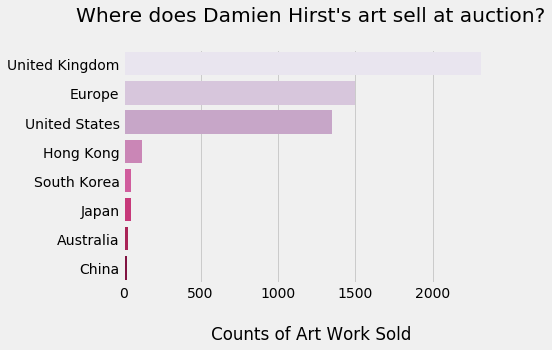

In [37]:
sns.barplot(x=sale_locations['Count'], y=sale_locations['Country'], palette='PuRd')
plt.title("Where does Damien Hirst's art sell at auction?\n")
plt.ylabel(None)
plt.xlabel('\nCounts of Art Work Sold');

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


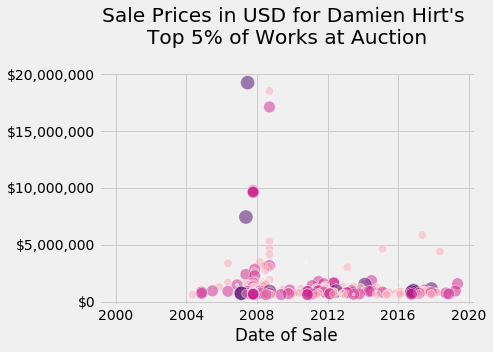

In [41]:
high_end = result.sort_values(by=['Realized_Price'], ascending=False)
high_end = high_end.head(255)

fmt = lambda x: "${:0,.0f}".format(x)
y_marks = [0,5000000,10000000,15000000,20000000]

sns.scatterplot(x=high_end['Date'], y=high_end['Realized_Price'], hue=high_end['Performance'], palette='RdPu',size=high_end['Performance'], sizes=(10,200), alpha=.5, legend=False)
plt.title("Sale Prices in USD for Damien Hirt's \nTop 5% of Works at Auction\n")

plt.yticks(y_marks, [fmt(i) for i in y_marks])
plt.ylabel(None)
plt.xlabel("Date of Sale");

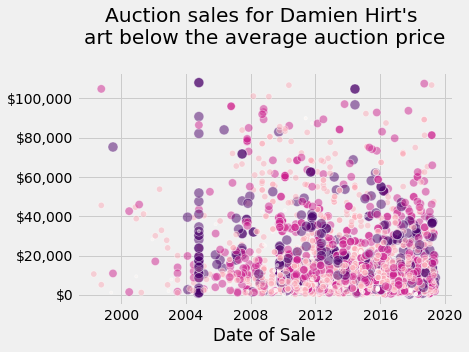

In [46]:
low_mkt = result[(result['Realized_Price'] <= result['Realized_Price'].mean())]
low_mkt = low_mkt[(low_mkt['Realized_Price'] > 0)]


fmt = lambda x: "${:0,.0f}".format(x)
y_marks = [0,20000,40000,60000,80000,100000]

sns.scatterplot(x=low_mkt['Date'], y=low_mkt['Realized_Price'], hue=low_mkt['Performance'], palette='RdPu', size=low_mkt['Performance'], alpha=.5, sizes=(10,100), legend=False)
plt.title("Auction sales for Damien Hirt's \nart below the average auction price\n")
plt.yticks(y_marks, [fmt(i) for i in y_marks])
plt.ylabel(None)
plt.xlabel('Date of Sale');

In [47]:
high_end['Performance'].value_counts()

2    147
3     77
1     20
4     11
Name: Performance, dtype: int64

In [48]:
low_mkt['Performance'].value_counts()

2    1417
3     816
4     340
1     315
Name: Performance, dtype: int64

In [50]:
low_counts = [2192, 1417, 816, 340]
low_percent = [x/4765 for x in low_counts]
low_performance = pd.DataFrame({'Rating': ['Poor', 'Good', 'Great', 'Exceptional'], 'Count': low_percent})
low_performance

,Rating,Count
0,Poor,0.46
1,Good,0.30
2,Great,0.17
3,Exceptional,0.07


In [51]:
high_counts = [20, 147, 77, 11]
high_percent = [x/255 for x in high_counts]
high_performance = pd.DataFrame({'Rating': ['Poor', 'Good', 'Great', 'Exceptional'], 'Count': high_percent})
high_performance

,Rating,Count
0,Poor,0.08
1,Good,0.58
2,Great,0.30
3,Exceptional,0.04


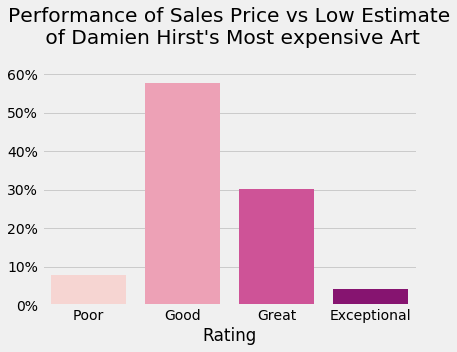

In [52]:
sns.barplot(x=high_performance['Rating'], y=high_performance['Count'], palette='RdPu')
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plt.ylabel(None)
plt.title("Performance of Sales Price vs Low Estimate\n of Damien Hirst's Most expensive Art\n");

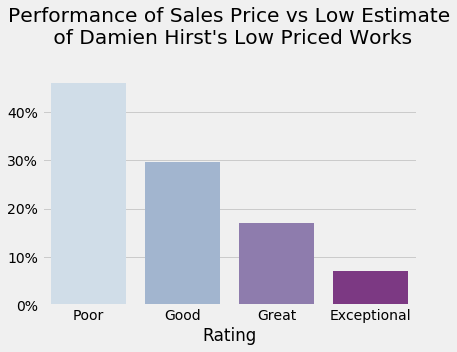

In [53]:
sns.barplot(x=low_performance['Rating'], y=low_performance['Count'], palette='BuPu')
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plt.ylabel(None)
plt.title("Performance of Sales Price vs Low Estimate\n of Damien Hirst's Low Priced Works\n");